# <span style='color:dodgerblue; font-weight:bold;'>UFO Sighting</span>

### <span style='color:aqua; font-weight:bold;'>Inspiration</span>
* What areas of the country are most likely to have UFO sightings?
* Are there any trends in UFO sightings over time? Do they tend to be clustered or seasonal?
* Do clusters of UFO sightings correlate with landmarks, such as airports or government research centers?
* What are the most common UFO descriptions?

### <span style='color:aqua; font-weight:bold;'> Import Packages and Load the data</span> 

In [1]:
# Essentials
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.offline as py
import plotly.graph_objects as go
import missingno as msno

# Misc
import spacy
from sklearn.impute import SimpleImputer
from wordcloud import WordCloud


# Ignore useless warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
ufo_df = pd.read_csv('scrubbed.csv', low_memory=False) # low_memory to avoid warnings

# <span style='color:dodgerblue; font-weight:bold;'> Exploratory Data Analysis</span> 

In [3]:
ufo_df.shape

(80332, 11)

In [4]:
ufo_df.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611


In [5]:
ufo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              80332 non-null  object 
 1   city                  80332 non-null  object 
 2   state                 74535 non-null  object 
 3   country               70662 non-null  object 
 4   shape                 78400 non-null  object 
 5   duration (seconds)    80332 non-null  object 
 6   duration (hours/min)  80332 non-null  object 
 7   comments              80317 non-null  object 
 8   date posted           80332 non-null  object 
 9   latitude              80332 non-null  object 
 10  longitude             80332 non-null  float64
dtypes: float64(1), object(10)
memory usage: 6.7+ MB


Converting timeseries "object" features to "datetime" data types

In [6]:
# converting from object to datetime data type
ufo_df['datetime'] = pd.to_datetime(ufo_df['datetime'], errors='coerce')
ufo_df['duration (seconds)'] = pd.to_datetime(ufo_df['duration (seconds)'], errors='coerce')
ufo_df['date posted'] = pd.to_datetime(ufo_df['date posted'], errors='coerce')

# drop the "duration (hours/min)" feature because its same as "duration (seconds)", so no need for it.
ufo_df.drop('duration (hours/min)',axis=1, inplace=True)

print(ufo_df['datetime'].dtype)
print(ufo_df['duration (seconds)'].dtype)
print(ufo_df['date posted'].dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]


Converting categorical values to numarical values

In [7]:
ufo_df['latitude'] = pd.to_numeric(ufo_df['latitude'], errors='coerce')
ufo_df['latitude'].dtype

dtype('float64')

In [8]:
# Sort the dataset features to quantitative and qualitative categories.
quantitative_cols = []
qualitative_cols = []
for col in ufo_df.columns:
    if pd.api.types.is_numeric_dtype(ufo_df[col]):
            quantitative_cols.append(col)
    else:
        qualitative_cols.append(col)

print("Qualitative Columns: ")
print(qualitative_cols)

print("Quantitative Columns: ")
print(quantitative_cols)

Qualitative Columns: 
['datetime', 'city', 'state', 'country', 'shape', 'duration (seconds)', 'comments', 'date posted']
Quantitative Columns: 
['latitude', 'longitude ']


In [9]:
# make sure all features have the correct data type.
ufo_df.dtypes.value_counts() # data types

object            5
datetime64[ns]    3
float64           2
dtype: int64

In [10]:
ufo_df.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,80331.0,38.124477,10.469636,-82.862752,34.134722,39.411111,42.788333,72.7000
longitude,80332.0,-86.772885,39.697205,-176.658056,-112.073333,-87.903611,-78.755000,178.4419


In [11]:
ufo_df['country'].value_counts().head(10)

us    65114
ca     3000
gb     1905
au      538
de      105
Name: country, dtype: int64

# <span style='color:dodgerblue; font-weight:bold;'> Data Pre-processing </span>

### <span style='color:aqua; font-weight:bold;'> Data redundancy </span> 

In [12]:
# Check for duplicates across all columns
duplicated = ufo_df.duplicated()

# Print the number of duplicated instances
print("Number of duplicated instances:", duplicated.sum())

# Print the duplicated instances
print(ufo_df[duplicated])

Number of duplicated instances: 2
                 datetime       city state country  shape duration (seconds)  \
62690 2013-07-04 22:00:00   shakopee    mn      us  light                NaT   
70780 2013-08-30 21:45:00  haymarket    va      us  light                NaT   

                 comments date posted   latitude  longitude   
62690   Orange fast orbs.  2013-07-05  44.798056  -93.526667  
70780  2 bright lights...  2013-09-09  38.811944  -77.636667  


### <span style='color:aqua; font-weight:bold;'> Missing Values </span> 

In [13]:
# print the percentage of missing values for instances.
total = ufo_df.isnull().sum().sort_values(ascending = False)[ufo_df.isnull().sum().sort_values(ascending = False) != 0]
percent = ((ufo_df.isnull().sum() / ufo_df.isnull().count()).sort_values(ascending = False)[(ufo_df.isnull().sum() / ufo_df.isnull().count()).sort_values(ascending = False) != 0])
missing = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
print(missing)

                    Total   Percent
duration (seconds)  77332  0.962655
country              9670  0.120375
state                5797  0.072163
shape                1932  0.024050
datetime              694  0.008639
comments               15  0.000187
latitude                1  0.000012


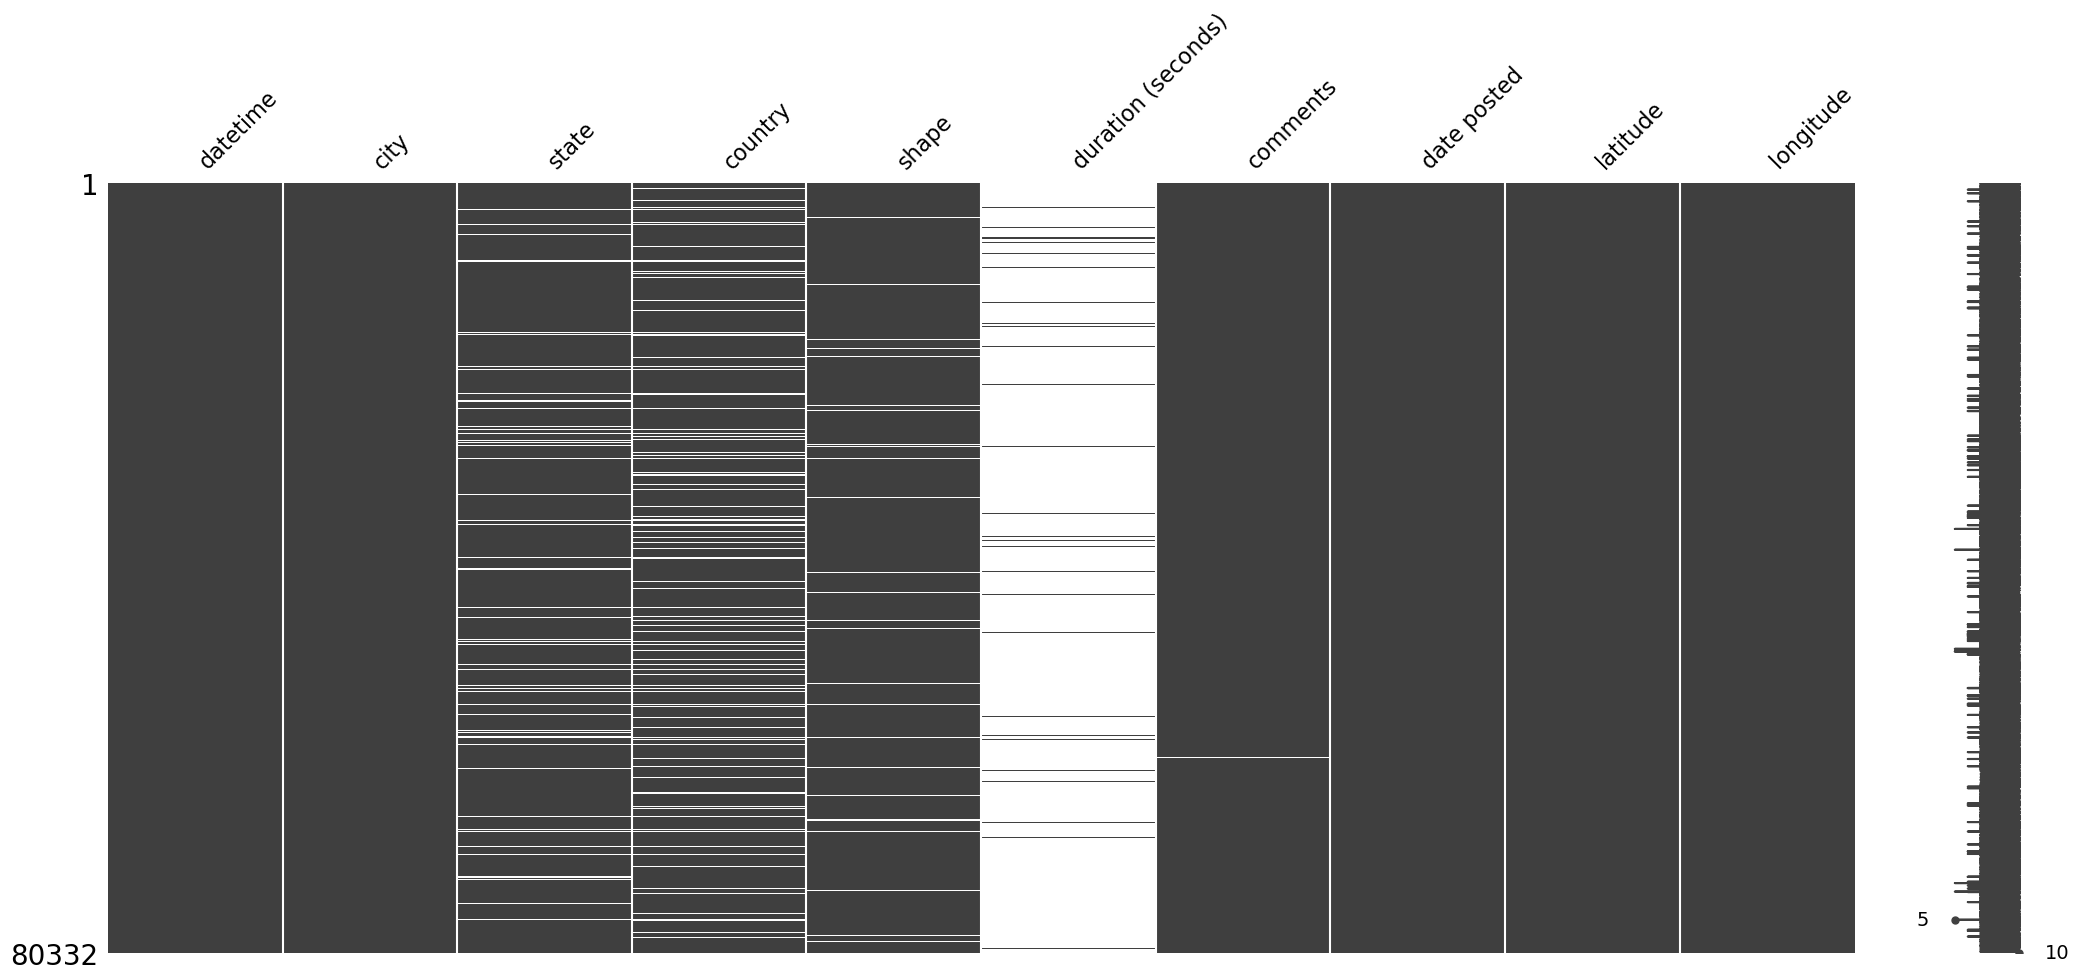

In [14]:
msno.matrix(ufo_df);

As shown in the previous plot, the "duration (seconds)" feature has 96% missing values, so we need to drop it as we can do nothing with it.

In [15]:
ufo_df.drop("duration (seconds)", axis=1, inplace=True)

Handling the missing values

In [16]:
# Handling missing values using SimpleImputer.
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer.fit(ufo_df[['datetime', 'state', 'country', 'shape', 'comments']])
ufo_df[['datetime', 'state', 'country', 'shape', 'comments']]=imputer.transform(ufo_df[['datetime', 'state', 'country', 'shape', 'comments']])
ufo_df['latitude'].fillna(int(ufo_df['latitude'].mean()), inplace=True)

In [17]:
# Check there is no more missing values.
ufo_df.isnull().sum()

datetime       0
city           0
state          0
country        0
shape          0
comments       0
date posted    0
latitude       0
longitude      0
dtype: int64

### <span style='color:aqua; font-weight:bold;'> Correlation </span> 


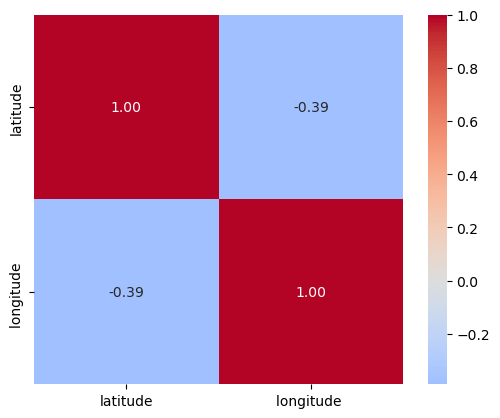

In [18]:
corr = ufo_df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f', center=0, square=True)
plt.show()

### <span style='color:aqua; font-weight:bold;'> Plot relationship between variables</span> 

In [19]:
ufo_yr = ufo_df['datetime'].dt.year

# Calculate the count of UFO sightings by year
years_data = ufo_yr.value_counts()
years_index = years_data.index
years_values = years_data.values

# Create the bar plot using Plotly
fig = go.Figure(data=go.Bar(x=years_index[:60], y=years_values[:60], marker_color='rgb(124, 176, 230)'))
fig.update_layout(
    title='UFO Sightings by Year',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Count'),
    xaxis_tickangle=-60,
    height=500,
    width=900
)

# Show the interactive plot
fig.show()

In [20]:
# Create a function to map months to seasons
def get_season(month):
    if month in range(3, 6):
        return 'Spring'
    elif month in range(6, 9):
        return 'Summer'
    elif month in range(9, 12):
        return 'Fall'
    else:
        return 'Winter'

# Apply the function to the 'datetime' column to get the season
ufo_df['season'] = ufo_df['datetime'].dt.month.apply(get_season)

# Calculate the count of sightings for each season
seasonal_counts = ufo_df['season'].value_counts()

# Create a DataFrame with the season and sightings count
df_seasonal_counts = pd.DataFrame({'Season': seasonal_counts.index, 'Sightings': seasonal_counts.values})

# Create the bar plot using Plotly
fig = px.bar(df_seasonal_counts, x='Season', y='Sightings', title='UFO Sightings by Season')
fig.update_layout(xaxis=dict(title='Season'), yaxis=dict(title='Sightings'))

# Show the interactive plot
fig.show()


In [21]:
# Filter out rows with missing datetime values
ufo_df_filtered = ufo_df.dropna(subset=['datetime'])

# Extract month from the datetime column
m_cts = ufo_df_filtered['datetime'].dt.month.value_counts().sort_index()

# Create a DataFrame with the month and sightings count
df_monthly_sightings = pd.DataFrame({'Month': m_cts.index, 'Sightings': m_cts.values})

# Create the line plot using Plotly
fig = px.line(df_monthly_sightings, x='Month', y='Sightings', title='Global UFO Sightings by Month')
fig.update_layout(xaxis=dict(title='Month'), yaxis=dict(title='UFO Sightings'), xaxis_tickangle=-45)

# Show the interactive plot
fig.show()


In [22]:
# Calculate the count of UFO sightings by day of the month
day_counts = ufo_df['datetime'].dt.day.value_counts()

# Create a DataFrame with the day of the month and counts
df_day_counts = pd.DataFrame({'Day': day_counts.index, 'Counts': day_counts.values})

# Create the countplot using Plotly
fig = px.bar(df_day_counts, x='Day', y='Counts', title='UFO Sightings by Day')
fig.update_layout(xaxis=dict(title='Day of Month'), yaxis=dict(title='Sighting Number'))

# Show the interactive plot
fig.show()


In [23]:
# Calculate the count of each shape
shape_counts = ufo_df['shape'].value_counts()

# Create a DataFrame with the shape and counts
df_shape_counts = pd.DataFrame({'Shape': shape_counts.index, 'Counts': shape_counts.values})

# Create the countplot using Plotly
fig = px.bar(df_shape_counts, x='Shape', y='Counts', title='Most frequent shape')
fig.update_layout(xaxis=dict(title='Shape'), yaxis=dict(title='Most frequent'))

# Rotate x-axis tick labels for better readability
fig.update_xaxes(tickangle=60)

# Show the interactive plot
fig.show()

In [24]:
# Calculate the count of UFO sightings by country
country_counts = ufo_df['country'].value_counts(dropna=False)

# Create a DataFrame with the country and sightings count
df_country_counts = pd.DataFrame({'Country': country_counts.index, 'Sightings': country_counts.values})

# Create the bar plot using Plotly
fig = px.bar(df_country_counts, x='Country', y='Sightings', title='Countries with the most UFO sightings')
fig.update_layout(xaxis=dict(title='Country'), yaxis=dict(title='Sightings'))

# Add annotations to the bars
for data in fig.data:
    fig.add_annotation(x=data['x'], y=data['y'], text=str(data['y']), showarrow=False, font=dict(size=10))

# Show the interactive plot
fig.show()

In [25]:
# Calculate the count of UFO sighting posts by year
year_counts = ufo_df['date posted'].dt.year.value_counts().sort_index()

# Create the line plot using Plotly
fig = go.Figure(data=go.Scatter(x=year_counts.index, y=year_counts.values, mode='lines'))
fig.update_layout(
    title="Posting the case's rates by years",
    xaxis=dict(title='Year'),
    yaxis=dict(title='Post Year'),
    xaxis_tickangle=0,
    height=500,
    width=900
)

# Show the interactive plot
fig.show()


In [26]:
states_us = ufo_df[ufo_df.country == "us"]["state"].value_counts()
states_us = states_us.sort_index()

# Create the bar plot using Plotly
fig = go.Figure(data=go.Bar(x=states_us.index, y=states_us.values, marker_color='rgb(124, 176, 230)'))
fig.update_layout(
    title="UFO Sightings by State in the US",
    xaxis=dict(title='State'),
    yaxis=dict(title='Count'),
    xaxis_tickangle=-70,
    height=600,
    width=1200
)

# Show the interactive plot
fig.show()

In [27]:
# Make a USA UFO Sighting map
states_us = ufo_df[ufo_df.country == "us"]["state"].value_counts().index
states_ratio = ufo_df[ufo_df.country == "us"]["state"].value_counts().values
states_us = [i.upper() for i in states_us]

data = [
    dict(
        type='choropleth',
        locations=states_us,
        z=states_ratio,
        locationmode='USA-states',
        text="times",
        marker=dict(
            line=dict(
                color='rgb(255,255,255)',
                width=2
            )
        ),
        colorbar=dict(
            title="Sight rates by states"
        ),
        colorscale='Blues'  # Set the color scale to blue
    )
]

layout = dict(
    title='UFO Sight Rates from USA',
    geo=dict(
        scope='usa',
        projection=dict(type='albers usa'),
        showlakes=True,
        lakecolor='rgb(255, 255, 255)'
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

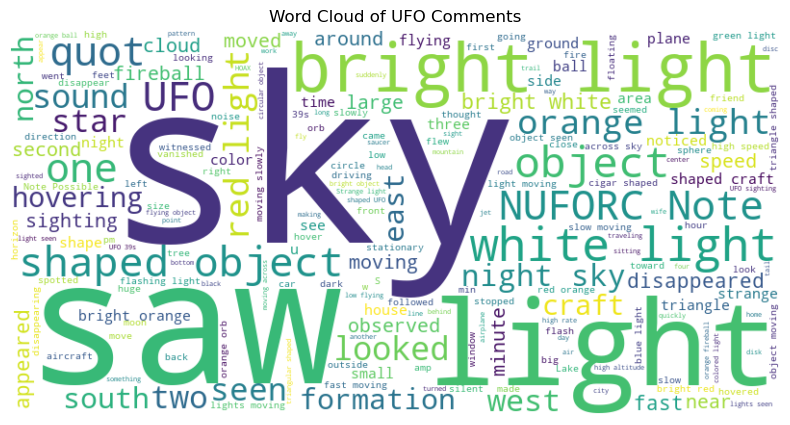

In [28]:

words = [i for i in ufo_df.comments.dropna()]
words = " ".join(words)

wordcloud = WordCloud(
    background_color='white',
    width=800,
    height=400
).generate(words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of UFO Comments')
plt.show()

# <span style='color:dodgerblue; font-weight:bold;'>Inspirations Answers</span>
* <b>What areas of the country are most likely to have UFO sightings?</b>

    According to our analysis of nationwide data, California (CA) exhibits the highest likelihood of UFO sightings.
    
* <b>Are there any trends in UFO sightings over time? Do they tend to be clustered or seasonal?</b>

    Indeed, we have observed discernible trends in UFO sightings over time. Our analysis, which includes plotting UFO sightings by season, reveals that summer is the predominant season for such sightings.

* <b>Do clusters of UFO sightings correlate with landmarks, such as airports or government research centers?</b>

    No, our comprehensive analysis, including the examination of comments through a word cloud feature, indicates a lack of significant correlation between clusters of UFO sightings and prominent landmarks such as airports or government research centers.

* <b>What are the most common UFO descriptions?</b>
    According to the word cloud analysis, prevalent UFO descriptions include terms such as "sky," "light," "saw," "white," and other related expressions.
